In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import joblib
import gc
import warnings
import sys
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier
from joblib import parallel_backend
import dill
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.metrics import confusion_matrix
sb.set()

In [146]:
def getsize(model):
  p = pickle.dumps(model)
  return sys.getsizeof(p)

In [147]:
# Define custom function for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

# Define a custom function that calculates the harmonic mean of sensitivity and specificity
def harmonic_mean(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    return 2 * (sensitivity * specificity) / (sensitivity + specificity)

# Create a custom scorer
custom_scorer = make_scorer(harmonic_mean, greater_is_better=True)

# #1

In [173]:
patient_combo = '1_2_3_5_6_8'

In [174]:
time_1=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/time_1.csv")
freq_1=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/freq_1.csv")

combined_1 = pd.concat([time_1, freq_1], axis=1)
combined_1=combined_1[combined_1['0']!=2]
combined_1.dropna(inplace=True)
combined_1

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,143.968750,161,111,111.499023,10.559310,144.355464,143.968750,0.0,50,...,-1.483668,100.821029,127.048925,7.200825,-0.358153,124.260687,170.093379,9.220853,-1.223775,183.862765
2,0,146.312500,161,131,81.152344,9.008460,146.589563,146.312500,0.0,30,...,-1.009653,101.648473,154.246451,7.300826,-0.933107,154.559325,143.516619,7.847521,-0.244196,148.518015
3,0,146.156250,161,121,71.850586,8.476472,146.401844,146.156250,0.0,40,...,-1.451995,66.301183,142.090666,7.600675,-1.099871,139.241200,216.002860,8.977859,-1.088425,220.601423
4,0,142.875000,161,121,83.984375,9.164299,143.168607,142.875000,0.0,40,...,-1.151256,55.846082,65.260270,8.708174,-0.634719,63.105010,122.744490,8.529022,-0.859514,127.142259
5,0,143.187500,161,121,51.464844,7.173900,143.367099,143.187500,0.0,40,...,0.030213,70.748469,93.172080,7.374633,-0.227154,90.842992,166.729780,9.722515,-1.391887,163.225201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57499,1,-161.828125,2707,-1888,309590.986084,556.409010,579.464691,309.390625,4.0,4595,...,1.661669,18973.757802,25410.346184,4.757743,1.460613,25499.657078,7871.863902,10.025579,-1.382934,8117.017419
57500,1,-168.312500,484,-1282,68776.621094,262.252972,311.617905,209.593750,2.0,1766,...,3.458455,7363.361565,4928.684117,5.780252,1.434548,4292.118885,2342.344435,6.092507,3.161030,2227.323341
57501,1,-147.828125,1424,-1252,116943.861084,341.970556,372.554715,238.296875,4.0,2676,...,8.505408,11965.230785,14384.521527,5.530174,2.511808,14531.015025,16339.458985,10.325112,-1.367546,16346.924920
57502,1,-196.437500,1868,-4767,581555.839844,762.598085,787.491925,402.281250,4.0,6635,...,2.062855,18784.944759,21677.068193,3.550188,2.848633,21731.262173,7381.908840,6.097441,2.017772,7135.649257


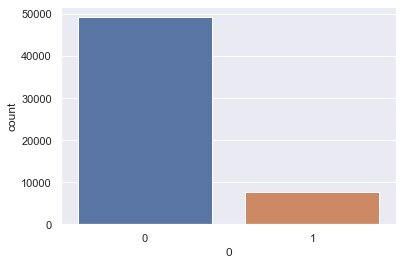

In [175]:
X = combined_1.drop('0', axis=1)
y = combined_1['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [176]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

Accuracy: 0.6765882281282358
Precision: 0.6441057078949548
Recall: 0.7892920228209449
F1-Score: 0.7093460331362675
Sensitivity: 0.7892920228209449
Specificity: 0.5638844334355267


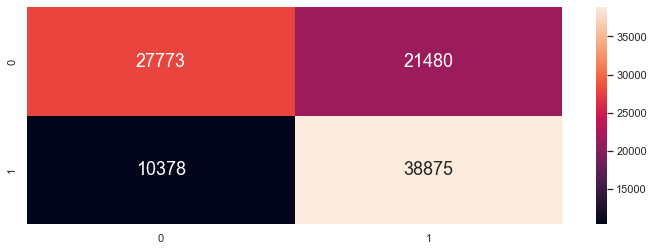

In [177]:
search = joblib.load(f"{patient_combo}/Models/dt_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.6750857815767567
Precision: 0.6425301224732658
Recall: 0.7892920228209449
F1-Score: 0.7083895185684609
Sensitivity: 0.7892920228209449
Specificity: 0.5608795403325686


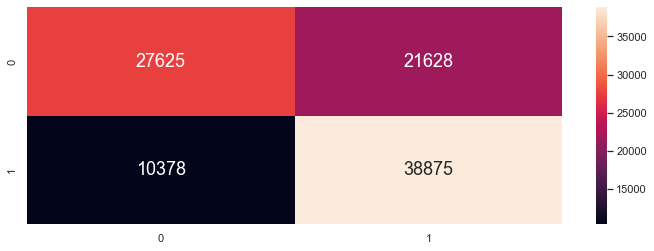

In [178]:
search = joblib.load(f"{patient_combo}/Models/xgb_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


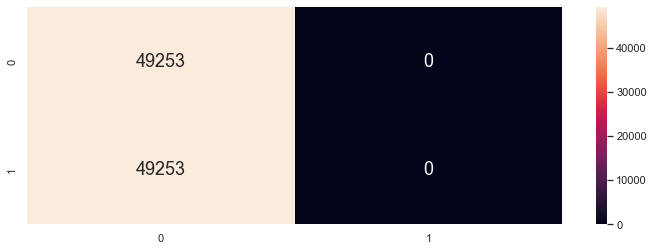

In [179]:
search = joblib.load(f"{patient_combo}/Models/knn_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()


print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

# #2

In [180]:
time_2=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/time_2.csv")
freq_2=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/freq_2.csv")

combined_2 = pd.concat([time_2, freq_2], axis=1)
combined_2=combined_2[combined_2['0']!=2]
combined_2.dropna(inplace=True)
combined_2

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,146.234375,161,121,76.507568,8.746860,146.495734,146.234375,0.0,40,...,-1.284377,83.990290,173.586377,8.865989,-0.982529,87.593598,341.548794,7.862881,-0.728384,173.052831
2,0,143.031250,161,121,67.749023,8.230979,143.267887,143.031250,0.0,40,...,-1.283907,62.101208,166.526412,10.033538,-1.265166,81.073151,244.514794,8.906718,-0.915740,121.205456
3,0,150.843750,171,121,98.413086,9.920337,151.169607,150.843750,0.0,50,...,-1.143582,82.747730,219.185043,8.930989,-0.951647,111.379771,314.809530,8.961263,-0.672711,159.715742
4,0,155.843750,171,131,70.288086,8.383799,156.069095,155.843750,0.0,40,...,-0.819683,74.821345,167.483017,7.658153,-0.328723,83.268043,250.417053,9.540549,-1.362890,119.394011
5,0,151.625000,171,131,87.109375,9.333240,151.911981,151.625000,0.0,40,...,-1.249441,86.386732,180.567569,8.485077,-0.909777,91.208555,351.093059,9.026296,-1.208163,175.247768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33246,1,-212.781250,-121,-555,3342.139648,57.811242,220.494898,212.781250,0.0,434,...,7.976103,3109.758017,11875.692583,5.324020,4.481550,5865.946519,6786.460318,9.701656,-1.397758,3422.585931
33247,1,-138.929688,1070,-616,34618.190369,186.059642,232.206047,181.726562,5.0,1686,...,5.840698,11938.751674,6413.508693,5.082923,3.122238,3134.650710,11657.534048,6.331695,2.264241,6002.581780
33248,1,-169.867188,2707,-4000,369040.318298,607.486887,630.789331,320.570312,8.0,6707,...,5.044006,8854.098434,22903.576170,5.561472,2.842575,11169.002538,20033.252278,10.429474,-1.405811,10198.144470
33249,1,-158.070312,1424,-1282,92965.143494,304.901859,343.440486,223.945312,6.0,2706,...,5.290342,13323.300193,15839.203213,6.362756,0.739057,7857.497693,20636.575331,8.890450,-0.118322,10460.701578


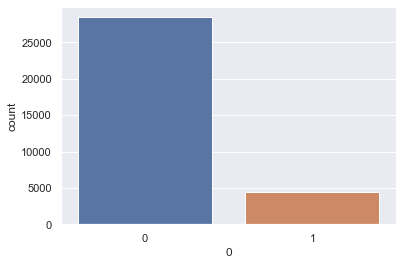

In [181]:
X = combined_2.drop('0', axis=1)
y = combined_2['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [182]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

Accuracy: 0.6785789584651065
Precision: 0.6435998869737214
Recall: 0.8003724787406001
F1-Score: 0.7134757549179301
Sensitivity: 0.8003724787406001
Specificity: 0.5567854381896128


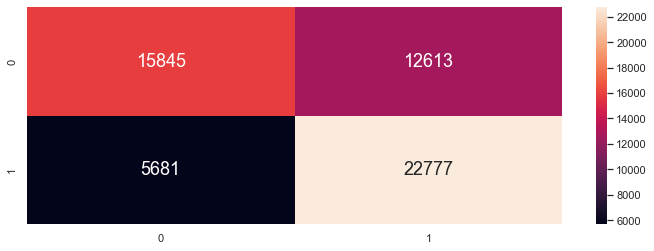

In [183]:
search = joblib.load(f"{patient_combo}/Models/dt_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.6769801110408321
Precision: 0.641949212254446
Recall: 0.8003724787406001
F1-Score: 0.71246031373653
Sensitivity: 0.8003724787406001
Specificity: 0.553587743341064


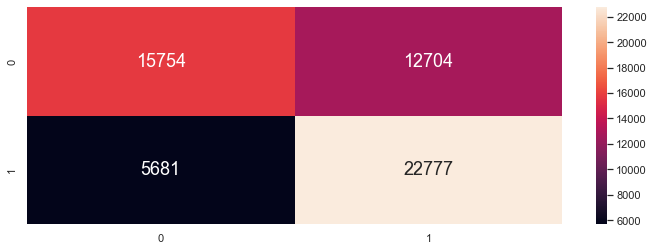

In [184]:
search = joblib.load(f"{patient_combo}/Models/xgb_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


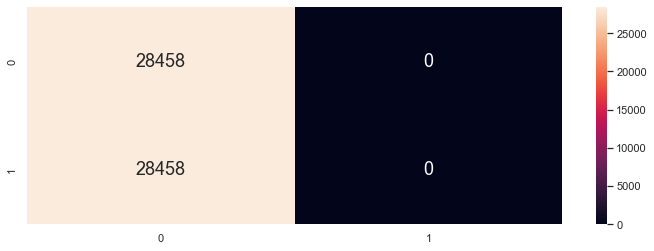

In [185]:
search = joblib.load(f"{patient_combo}/Models/knn_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()


print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

# #3

In [186]:
time_3=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/time_3.csv")
freq_3=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/freq_3.csv")

combined_3 = pd.concat([time_3, freq_3], axis=1)
combined_3=combined_3[combined_3['0']!=2]
combined_3.dropna(inplace=True)
combined_3

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,144.072917,161,121,71.286350,8.443124,144.320101,144.072917,0.0,40,...,-1.221117,55.807247,268.180305,9.189805,-1.201856,87.912127,419.604150,9.171086,-0.971242,138.459806
2,0,152.145833,171,121,92.437066,9.614420,152.449309,152.145833,0.0,50,...,-1.362317,91.170150,334.615002,8.797424,-1.026755,111.911560,551.100425,9.722320,-1.162917,187.748606
3,0,153.395833,171,131,86.968316,9.325680,153.679049,153.395833,0.0,40,...,-1.000443,91.941980,324.129212,8.611510,-0.783062,108.154231,543.224150,8.796760,-1.244048,181.781062
4,0,135.635417,161,101,120.700412,10.986374,136.079634,135.635417,0.0,60,...,-1.245447,113.657979,283.297528,9.494759,-1.377133,93.425888,547.825309,9.519770,-1.392860,179.995860
5,0,135.427083,161,111,153.838433,12.403162,135.993872,135.427083,0.0,50,...,-1.399864,107.356173,315.574455,8.666549,-1.093229,105.845222,410.707752,9.436994,-1.158150,133.264200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25104,1,-221.395833,1303,-1666,130474.384983,361.212382,423.663192,318.406250,6.5,2969,...,5.300557,17238.091178,35548.576009,4.965161,3.349228,12217.810851,35523.803153,6.099677,1.129934,12251.271178
25105,1,-202.005208,-10,-555,5147.557265,71.746479,214.368051,202.005208,0.0,545,...,10.107919,2745.142737,11382.092792,5.046247,5.837321,3711.254359,8915.271634,9.345960,-0.953310,3051.219872
25106,1,-145.713542,2707,-4000,266435.787733,516.174184,536.347111,274.713542,13.0,6707,...,4.293087,7633.285386,27350.079608,5.628157,3.126733,9076.919318,32420.597212,10.279633,-1.309036,10764.543226
25107,1,-170.859375,1868,-4767,256155.829183,506.118394,534.180452,283.390625,10.0,6635,...,5.374599,12199.190280,30439.194923,5.927679,1.497921,10201.338210,33216.569911,9.529312,-0.728003,11317.183109


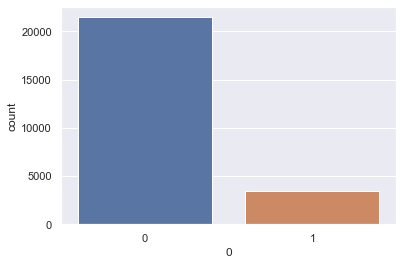

In [187]:
X = combined_3.drop('0', axis=1)
y = combined_3['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [188]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

Accuracy: 0.6781472684085511
Precision: 0.6427984768162472
Recall: 0.8019188673093941
F1-Score: 0.7135959549909857
Sensitivity: 0.8019188673093941
Specificity: 0.5543756695077081


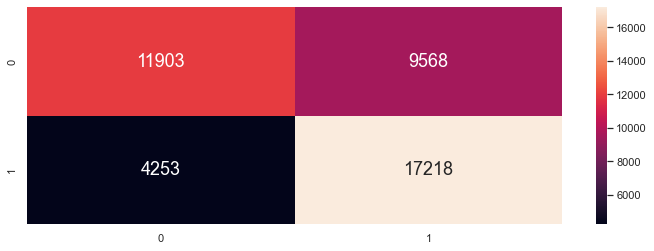

In [189]:
search = joblib.load(f"{patient_combo}/Models/dt_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.676587024358437
Precision: 0.6411946523665885
Recall: 0.8019188673093941
F1-Score: 0.7126065723036173
Sensitivity: 0.8019188673093941
Specificity: 0.5512551814074799


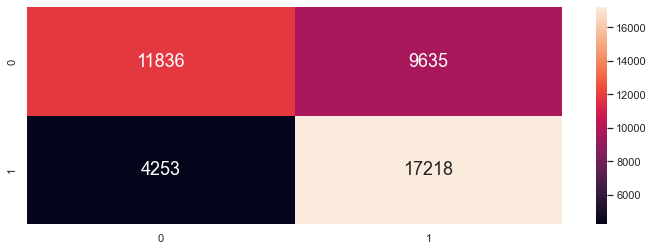

In [190]:
search = joblib.load(f"{patient_combo}/Models/xgb_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


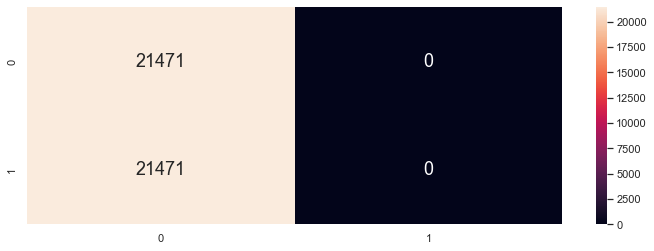

In [191]:
search = joblib.load(f"{patient_combo}/Models/knn_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()


print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

# #4

In [192]:
time_4=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/time_4.csv")
freq_4=pd.read_csv(f"{patient_combo}/Labelled_Files_Test/features/freq_4.csv")

combined_4 = pd.concat([time_4, freq_4], axis=1)
combined_4=combined_4[combined_4['0']!=2]
combined_4.dropna(inplace=True)
combined_4

,0,mean_A_F,max_A_F,min_A_F,var_A_F,std_A_F,rms_A_F,mav_A_F,zcr_A_F,p2p_A_F,...,spectral_kurtosis_T_F,bandpower_T_F,PSD_T_V,spectral_spread_T_V,spectral_kurtosis_T_V,bandpower_T_V,PSD_T_L,spectral_spread_T_L,spectral_kurtosis_T_L,bandpower_T_L
1,0,146.937500,171,121,98.339844,9.916645,147.271751,146.937500,0.0,50,...,-0.965929,76.244062,356.825464,9.349785,-1.132259,89.887146,532.128395,9.936602,-1.285854,133.881668
2,0,153.734375,171,131,83.148193,9.118563,154.004566,153.734375,0.0,40,...,-1.107565,85.512156,395.899617,8.637407,-0.770876,98.906420,635.774065,9.181366,-1.293362,158.065221
3,0,133.382812,161,101,122.837830,11.083223,133.842491,133.382812,0.0,60,...,-1.163546,100.523645,401.785442,9.405047,-1.416882,101.462884,810.655524,9.683704,-1.375860,201.795168
4,0,139.085938,171,111,117.820740,10.854526,139.508848,139.085938,0.0,60,...,-1.188534,129.869051,440.457115,9.079017,-1.148885,105.958133,963.762395,11.487377,-1.218666,255.273979
5,0,112.886719,141,80,220.920761,14.863403,113.861021,112.886719,0.0,61,...,0.672424,267.140045,377.816693,8.511748,-1.141525,93.860939,934.649675,10.718648,-1.479536,235.520409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20988,1,-181.800781,1232,-2383,102022.182968,319.409115,367.523750,236.597656,9.0,3615,...,1.661619,16799.812700,88500.824362,6.144450,1.477628,22094.092907,50904.925969,8.718549,-0.795953,12860.419286
20989,1,-166.324219,1303,-1666,155810.969101,394.728982,428.339486,298.394531,17.5,2969,...,4.724047,17940.634327,70356.014884,5.784742,2.688476,17522.910684,47135.518638,8.453140,-0.084640,11641.916564
20990,1,-211.085938,-10,-555,4432.461365,66.576733,221.336247,211.085938,0.0,545,...,9.682394,3481.541007,17607.264183,5.264692,4.911708,4503.112923,13060.584160,9.434699,-0.982694,3279.387134
20991,1,-147.863281,2454,-4000,168918.469589,410.996922,436.786011,240.660156,15.5,6454,...,5.164006,9803.348237,41488.706166,5.288203,2.910788,10435.107045,38399.385014,10.210016,-1.211091,9636.821835


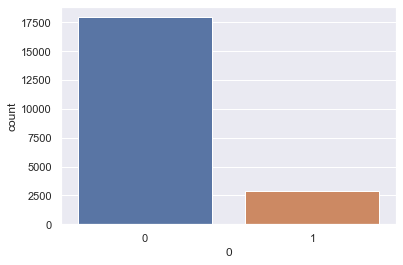

In [193]:
X = combined_4.drop('0', axis=1)
y = combined_4['0']

sb.countplot(data=pd.DataFrame(y), x='0')
plt.show()

In [194]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

Accuracy: 0.6854969065269494
Precision: 0.6470874215504288
Recall: 0.8160637645616187
F1-Score: 0.7218182266374146
Sensitivity: 0.8160637645616187
Specificity: 0.5549300484922802


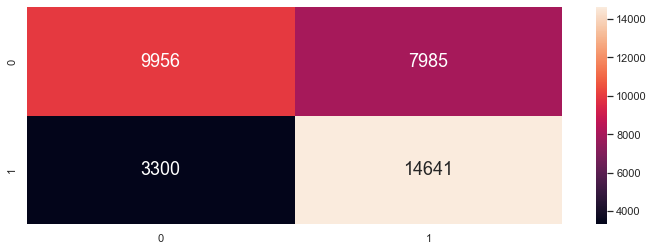

In [195]:
search = joblib.load(f"{patient_combo}/Models/dt_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.6835739367928209
Precision: 0.6451200705001101
Recall: 0.8160637645616187
F1-Score: 0.7205925780096466
Sensitivity: 0.8160637645616187
Specificity: 0.5510841090240232


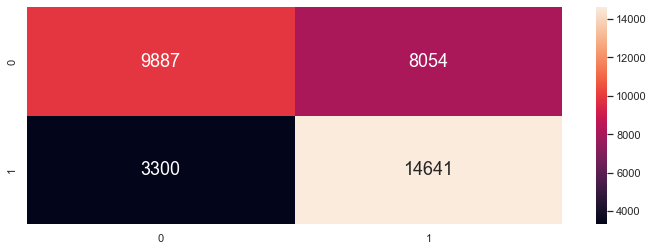

In [196]:
search = joblib.load(f"{patient_combo}/Models/xgb_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()

print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


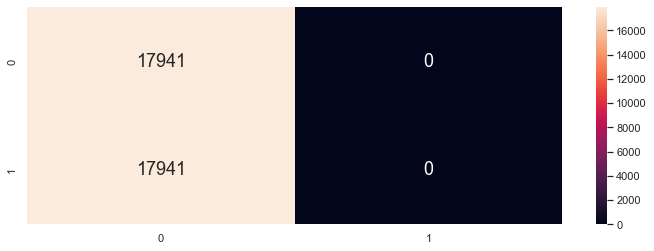

In [197]:
search = joblib.load(f"{patient_combo}/Models/knn_new_model_1.joblib")

rf_y_pred = search.predict(X)

tn, fp, fn, tp = confusion_matrix(y, rf_y_pred).ravel()


print('Accuracy:', accuracy_score(y, rf_y_pred))
print('Precision:', precision_score(y, rf_y_pred))
print('Recall:', recall_score(y, rf_y_pred))
print('F1-Score:', f1_score(y, rf_y_pred))

# Calculate Sensitivity
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


f, axes = plt.subplots(1, 1, figsize=(12, 4))
sb.heatmap(confusion_matrix(y, rf_y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

# 1 3 5 8 9

w = 1:

DTree
--------
Sens: 46.5%
Spec: 40.6%

XGB
------
Sens: 68.1%
Spec: 38.9%

KNN
------
Sens: 23.1%
Spec: 83.5%

w = 2:

DTree
--------
Sens: 49.7%
Spec: 39.8%

XGB
------
Sens: 69.7%
Spec: 38.8%

KNN
------
Sens: 27.6%
Spec: 81.3%

w = 3:

DTree
--------
Sens: 48.8%
Spec: 39.4%

XGB
------
Sens: 71.0%
Spec: 38.7%

KNN
------
Sens: 29.7%
Spec: 80.4%

w = 4:

DTree
--------
Sens: 47.7%
Spec: 38.8%

XGB
------
Sens: 70.0%
Spec: 38.6%

KNN
------
Sens: 29.7%
Spec: 80.0%

# 2 3 6 8 9

w = 1:

DTree
--------
Sens: 0%
Spec: 99.7%

XGB
------
Sens: 1.3%
Spec: 99.3%

KNN
------
Sens: 2.0%
Spec: 98.9%

w = 2:

DTree
--------
Sens: 100.0%
Spec: 0.0%

XGB
------
Sens: 39.7%
Spec: 89.1%

KNN
------
Sens: 3.4%
Spec: 97.7%

w = 3:

DTree
--------
Sens: 0.0%
Spec: 94.2%

XGB
------
Sens: 16.9%
Spec: 91.0%

KNN
------
Sens: 83.2%
Spec: 98.2%

w = 4:

DTree
--------
Sens: 25.3%
Spec: 56.4%

XGB
------
Sens: 2.3%
Spec: 99.4%

KNN
------
Sens: 14.4%
Spec: 86.6%

# 3 5 6 7 9

w = 1:

DTree
--------
Sens: 55.8%
Spec: 67.6%

XGB
------
Sens: 82.4%
Spec: 62.9%

KNN
------
Sens: 0.0%
Spec: 99.4%

w = 2:

DTree
--------
Sens: 95.4%
Spec: 52.6%

XGB
------
Sens: 90.2%
Spec: 57.5%

KNN
------
Sens: 9.0%
Spec: 97.0%

w = 3:

DTree
--------
Sens: 30.5%
Spec: 49.1%

XGB
------
Sens: 75.9%
Spec: 70.4%

KNN
------
Sens: 0.9%
Spec: 98.2%

w = 4:

DTree
--------
Sens: 27.9%
Spec: 49.1%

XGB
------
Sens: 71.3%
Spec: 75.9%

KNN
------
Sens: 0.0%
Spec: 99.8%